# Assignment 3

**Deadline**:  25/09/2019, 9.59am

**Names and student numbers:**
1. Vien Dinh (11002115)
2. Dante van der Heijden (11020075)
3. Jorrim Prins (11038934)

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignment group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

**Exercise 1:** import the relevant libraries.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# Part 1: analyzing the relation between Twitter sentiment and stock prices

**Example:** in the cell below, Twitter sentiment data and stock price data for the company Nike, Inc. (NKE) is imported as two pandas DataFrames. The data is covering a period of approximately 16 months in 2013 and 2014.

In [3]:
df1 = pd.read_csv("twitter_data_NKE.csv", index_col=0);
df2 = pd.read_csv("financial_data_NKE.csv", index_col=0);

**Exercise 2:** in this exercise, you will be asked to use the data of Nike to quantify the relation between Twitter sentiment and the stock price. Twitter sentiment is sometimes condensed into a single number, called the *daily sentiment polarity*, given by 

$$ P_i = \frac{tw^+_i-tw^-_i}{tw^+_i+tw^-_i} \,, $$

where $tw^\pm_i$ is the number of positive/negative tweets on day $i$. As a measure for the daily return on the stock price on day $i$, we will use the ratio between the closing price on day $i$ and the closing price on the day before (day $i-1$). 

In this excercise we ask you to calculate two numbers, based on the data in `df1` and `df2`: the **(Pearson) correlation between the daily sentiment polarity and the daily return on the stock price** (on trading days), as well as **the p-value** for this correlation.

(NB: your answer will probably consist of multiple steps. Pay attention to how you structure your answer, such that it is easily readable and understandable for a third person. For example, make use of comments inside your code and/or divide your answer over multiple cells and provide commentary in markdown cells. Also, mention explicitly any decisions you had to make.)

In [4]:
# Add a column P to df1 containing the daily sentiment polarity for each compony
df1['P'] = (df1.NUM_POS - df1.NUM_NEG)/(df1.NUM_POS + df1.NUM_NEG)

# For this newly created column, set all NaN values to zero. 
# The NaN values are created because df1 also contains a column that indicates how many tweets are of neutral 
# sentiment. If the given day was completely "sentiment neutral" for a company, Pi is not calculateable, because
# either #twi+ = #twi-, or because there were no positive or negative tweets, only neutral tweets.
# Therefore, we swap the values with 0.
df1.P[df1.P.isna()] = 0 

# Add column named RETURN which is filled with values of the ratio between the closing price on day i and the
# closing price on the day before (i - 1). We do this efficiently by using the Pandas function pct_change(), 
# which calculates the percentage change between the current and a prior element, by default from the immediately
# previous row. Afterwards we add 1.
df2['RETURN'] = df2.pct_change().CLOSE + 1

# Use the first value of RETURN as an index. This value was calculated as NaN, since there is no value
# for t = -1
df2.RETURN[df2.RETURN.isna()] = 1 

# Now, let's create a new dataset were the columns we created in the previous steps, "P" and "RETURN", are joined.
# We filter for weekdays, since during the weekends markets are closed and therefore don't have daily returns.
df3 = pd.concat([df1.P,df2.RETURN],axis=1,join="inner")

# Now, as a final step, we use the stats module of scipy to calculate the wanted correlation and the p-value
print("The Pearson correlation for Nike's Twitter sentiment and daily stock returns is: {}".format(stats.pearsonr(df3.P,df3.RETURN)[0]))
print("The p-value for this correlation is: {}".format(stats.pearsonr(df3.P,df3.RETURN)[1]))

The Pearson correlation for Nike's Twitter sentiment and daily stock returns is: 0.3088521350580856
The p-value for this correlation is: 5.998495419000262e-09


# Part 2: ridge and lasso regression 
The data for this part of the assignment originates from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures of 97 men who were about to receive a radical prostatectomy. The DataFrame `df` in the cell below consists of nine columns: the first eight (*lcavol*, *lweight*, *age*, *lbph*, *svi*, *lcp*, *gleason*, *pgg45*) represent clinical measures and will be used as (input) features. The ninth column (*lpsa*) is the target variable.

In order to predict the target variable *lpsa*, we will use the following linear model:
$$ Y = f(X, \beta) + \epsilon, \qquad \text{with} \quad f(X,\beta) = \beta_0 + \sum_{m=1}^{16} \beta_m X_m, $$
where $\epsilon$ is randon noise, $X_1, X_2, \dots, X_8$ are simply the input features (*lcavol*, *lweight*, etc.) and $X_m = (X_{m-8})^2,$ for $m = 9, 10, \dots, 16.$

In [5]:
df = pd.read_csv("prostate_cancer.txt", sep="\t", index_col=0).drop(labels='train', axis=1)

print("(number of rows, number of columns) =", df.shape)
df.head(5)

(number of rows, number of columns) = (97, 9)


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


**Exercise 3:** add eight more columns to `df`, consisting of the squares of the eight input features. They represent the features $X_m = (X_{m-8})^2,$ for $m = 9, 10, \dots, 16,$ in the linear model described above. For the names of the columns, use the name of the original input feature and add the string `_sq` to it. For example, give the column for the square of *lcavol* the name `lcavol_sq`. Furthermore, make sure that the target variable *lpsa* remains the last (17th) column of `df`. Print the first 5 rows of the resulting `df`.

In [6]:
# First, we'll run a for-loop to easily create the requested columns with the corresponding column names.
for cols in df.iloc[:,:-1].columns:
    df[cols + '_sq'] = df[cols]**2
    
# Get a list of the column names    
cols = df.columns.tolist()

# Now, to create the "updated" dataframe containing the squares, make sure to remove the instances of lpsa_sq.
cols = cols[0:8] + cols[9:17] + cols[8].split(" ")
df = df[cols]
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lcavol_sq,lweight_sq,age_sq,lbph_sq,svi_sq,lcp_sq,gleason_sq,pgg45_sq,lpsa
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,0.336189,7.669903,2500,1.921812,0,1.921812,36,0,-0.430783
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,0.988538,11.019917,3364,1.921812,0,1.921812,36,0,-0.162519
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,0.260943,7.242789,5476,1.921812,0,1.921812,49,400,-0.162519
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,1.449551,10.776704,3364,1.921812,0,1.921812,36,0,-0.162519
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.564626,11.781184,3844,1.921812,0,1.921812,36,0,0.371564


**Exercise 4:** create a 2-dimensional NumPy array `X`, representing the 16 features, and a 1-dimensional NumPy array `y`, representing the target variable. Organize the rows and columns of `X` according to the standard format of the scikit-learn library.

In [7]:
# Reading the scikit-learn library specifications, two properties pop up: 
# 1. The target value must be in a different array as the features
# 2. Most scikit-learn estimators must be 2-dimensional. 
# Therefore, create the correct arrays.
X = df.loc[:, df.columns != 'lpsa'].values
y = df['lpsa'].values

**Exercise 5:** it seems very likely that the 16 features of our linear model suffer multicollinearity. Therefore, we ask you to use ridge regression for training the model. More concretely, in this exercise we ask you to plot two graphs:
* a graph showing the relation between the RMSE of a model trained with ridge regression (vertical axis) and the ridge parameter $\lambda$ (horizontal axis). The RMSE should be estimated with 10-fold cross-validation. Furthermore, the plot should include the one-standard-error errorbars of the RMSE estimates.
* a graph showing the relation between the values of the 16 coefficients in the model (vertical axis) and the ridge parameter $\lambda$ (horizontal axis).

For this exercise, please note the following:
* you may use the scikit-learn library as much as you want.
* it is up to you to choose a relevant range for the ridge parameter $\lambda.$
* it is advisable to use a logarithmic scale for the $\lambda$-axis in both graphs.
* ridge regression is (usually) performed on standardized features (mean of zero, standard deviation of one). See the documentation about the `sklearn.linear_model.Ridge` function on how this can be accomplished easily.
* the quality/clarity/attractiveness of the visualizations will be a grading criterium, but, for this exercise, is deemed less important than correctness of the solution and quality of the code. 

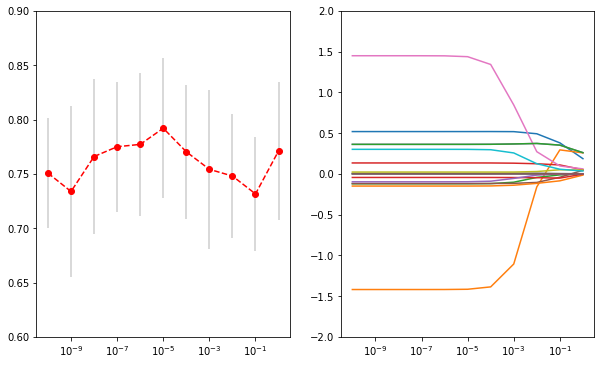

In [8]:
# Initilization step:
# Define possible lambdas, number of folds and initialize lists
lambdas = [10**i for i in range(-10,1)]
K = 10
RMSE_list = []
RMSE_stds = []
coeflists = [[] for i in range(X.shape[1])]

for lam in lambdas:
    # Define Ridge model with multiple lambdas and fit on the normalized data, which is easily obtained by
    # adding the parameter "normalize=True" to the scikit-learn Ridge function
    model = Ridge(alpha = lam, normalize=True).fit(X, y)
    
    # Determine crossval folds and mean/std of RMSE's, here we use the KFold function provided by scikitlearn
    # Another way would be to use the "custom made" KFolder which was created in the third computer class of this 
    # course. 
    cv_folds = KFold(n_splits=K, shuffle=True)
    RMSE = np.sqrt(-cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error'))
    RMSE_mean = np.mean(RMSE)
    RMSE_std = np.std(RMSE,ddof=1)/np.sqrt(K)   
    RMSE_list.append(RMSE_mean)
    RMSE_stds.append(RMSE_std)
    
    for i in range(X.shape[1]):
        coeflists[i].append(model.coef_[i])

# Create figure
fig1 = plt.figure(figsize=(10,6));
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

# Add errorbar plot for lambdas against RMSE, with logaritmhic horizontal scale
ax1.errorbar(lambdas, RMSE_list,yerr=RMSE_stds,fmt='ro--',ecolor='black',elinewidth=0.3)
ax1.set_ylim(bottom=0.6,top=0.9)
ax1.set_xscale('log')

for i in range(X.shape[1]):
    ax2.plot(lambdas, coeflists[i])
    ax2.set_ylim(bottom=-2,top=2)
    ax2.set_xscale('log')


plt.show()


**Exercise 6:** explain, in your own words, how the results of **Exercise 5** are an illustration of the bias-variance decomposition/trade-off. Include **both** graphs in your explanation.

#### ANSWER IN PLAIN TEXT: ####
The bias-variance decomposition/trade-off states that models with more complexity have a lower bias. However, this lowered bias comes at the expense of a higher variance. In this case, the weight of the second part of the Ridge regression minimisation criterion increases with a bigger $\lambda$ (thus resulting in a more complex model).  

From the left graph it may be concluded that the Root Mean Squared Error modereately decreases when lambda increases, which translates into a lower bias. Meanwhile, the right graph shows the relation between the values of the coefficients and the $\lambda$'s. When $\lambda$ is increased it pushes the coefficients towards zero, and simultanously the variance of these coefficient decomposes.

**Exercise 7:** use the one-standard-error rule to (roughly) determine an optimal value for $\lambda.$ Give your answer in the markdown cell below, and also explain your method for determining an optimal value for $\lambda.$

In [9]:
min_RMSE = min(RMSE_list)
min_lambda = lambdas[RMSE_list.index(min_RMSE)]
min_RMSE_std = RMSE_stds[RMSE_list.index(min_RMSE)]
max_RMSE = min_RMSE + RMSE_stds[RMSE_list.index(min(RMSE_list))]
itemindex = np.where(RMSE_list<max_RMSE)
OSE_lambda = lambdas[itemindex[0][0]]

print('For lambda =', min_lambda, 'the RMSE is the lowest')
print('The standard deviation of this RMSE is', min_RMSE_std)
print('The optimal value for lambda according to the one-standard-error is', OSE_lambda)

min_RMSE

For lambda = 0.1 the RMSE is the lowest
The standard deviation of this RMSE is 0.052145833386891945
The optimal value for lambda according to the one-standard-error is 1e-10


0.7316052328463336

#### ANSWER IN PLAIN TEXT: ####
For $\lambda =$ ```min_lambda``` the RMSE is the lowest. The one-standard-rule states that the least complex model whose CV error is no more than one standard deviation above the smallest error is selected. The chosen $\lambda$ has a RMSE of ```min_RMSE``` and a std of ```min_RMSE_std```, which means the $\lambda$ for which the model is the least complex within the one standard deviation is $\lambda =$ ```OSE_lambda```.

**Exercise 8:** repeat **Exercise 5**, but now use lasso instead of ridge regression. Remember that lasso is also (usually) performed on standardized features.

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Jorrim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


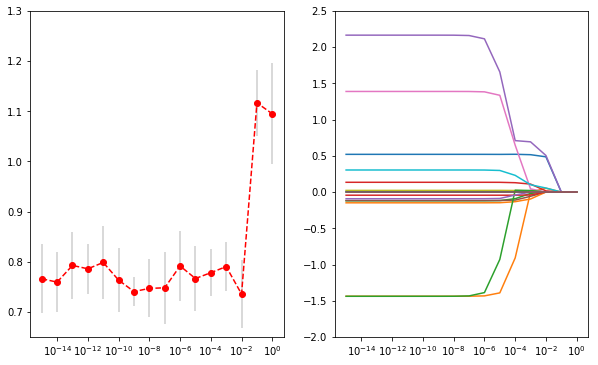

In [36]:
# Define possible lambdas, number of folds and initialize lists
lambdas = [10**i for i in range(-15,1)]
K = 10
RMSE_list = []
RMSE_stds = []
coeflists = [[] for i in range(X.shape[1])]

for lam in lambdas:
    # Define Ridge model with multiple lambdas and fit on the data (normalized)
    model = Lasso(alpha = lam, normalize=True).fit(X, y)
    
    # Determine crossval folds and mean/std of RMSE's 
    cv_folds = KFold(n_splits=K, shuffle=True)
    RMSE_mean = np.mean(np.sqrt(-cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')))
    RMSE_std = np.std(np.sqrt(-cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')),ddof=1)/np.sqrt(K)   
    RMSE_list.append(RMSE_mean)
    RMSE_stds.append(RMSE_std)
    
    for i in range(X.shape[1]):
        coeflists[i].append(model.coef_[i])

# Create figure
fig1 = plt.figure(figsize=(10,6));
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

# Add errorbar plot for lambdas against RMSE, with logaritmhic horizontal scale
ax1.errorbar(lambdas, RMSE_list,yerr=RMSE_stds,fmt='ro--',ecolor='black',elinewidth=0.3)
ax1.set_ylim(bottom=0.65,top=1.3)
ax1.set_xscale('log')

for i in range(X.shape[1]):
    ax2.plot(lambdas, coeflists[i])
    ax2.set_ylim(bottom=-2,top=2.5)
    ax2.set_xscale('log')

plt.show()


**Exercise 9:** sometimes the practical context of a data-science problem demands a model that is easy to understand, explain or interpret. Suppose you are asked to build a model for predicting *lpsa*, using **at most three features**. Which features would you choose? What is (approximately) the RMSE that we can expect from such a model? Motivate your answer. 

#### ANSWER IN PLAIN TEXT: ####
So, here we're looking at the case where lambda will be pushed to 1. Judging from second graph in the previous exercise, we're only intrested in the values of lambda between ```10e-3``` and ```10e-1```. Therefore, we first plot the graph again, only for these values.

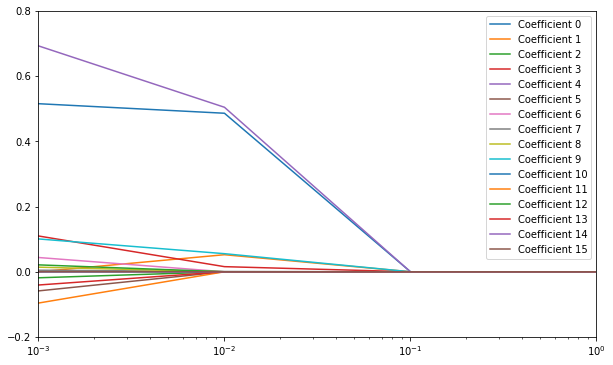

In [37]:
# Create figure
fig1 = plt.figure(figsize=(10,6));
ax1 = fig1.add_subplot(1,1,1)

for i in range(X.shape[1]):
    ax1.plot(lambdas, coeflists[i], label="Coefficient "+str(i))
    ax1.set_ylim(bottom=-0.2,top=0.8)
    ax1.set_xlim(left=10e-4, right=10e-1)
    ax1.set_xscale('log')
    plt.legend()

plt.show()

Now, we're searching for those parameter values that are, in absolute sense, furthest away from 0, since the Lasso regression will push the most irrelevant parameters to 0 for higher values of lambda. Easily seen is that Coefficient 0 and 4 have to be kept in the model, being ```lcavol```	and ```svi```. Now let's convert our earlier made ```coeflists```, containing the values of the coefficients for different values of lambda, to a Panda's DataFrame so we can say for certain that we're looking at the correct values.

In [38]:
colnames = []
for i in range(-15,0):
    colnames.append('10e'+str(i))
colnames.append('1')
lasso_optimal = pd.DataFrame(coeflists).rename_axis("Coefficients").rename_axis("Lambda Values", axis="columns")
lasso_optimal.columns = colnames
lasso_optimal.abs().nlargest(3, '10e-2')

,10e-15,10e-14,10e-13,10e-12,10e-11,10e-10,10e-9,10e-8,10e-7,10e-6,10e-5,10e-4,10e-3,10e-2,10e-1,1
Coefficients,,,,,,,,,,,,,,,,
4,2.164567,2.164567,2.164567,2.164567,2.164567,2.164562,2.164516,2.164059,2.159491,2.113806,1.656963,0.709538,0.692578,0.504381,0.0,0.0
0,0.520128,0.520128,0.520128,0.520128,0.520128,0.520128,0.520128,0.520127,0.520121,0.520064,0.519488,0.520988,0.515299,0.486044,0.0,0.0
9,0.304177,0.304177,0.304177,0.304177,0.304177,0.304177,0.304176,0.304171,0.304113,0.303532,0.297722,0.230177,0.100646,0.055484,0.0,0.0


First, we see that indeed, coefficient 4 and 0 are, in absolute terms, the most positive values at Lambda = e-12 (therefore we use the function ```.nlargest(3, '10e-2')```). Beside 4 and 0, coefficient 9 is most valuable in our model. To check the approximate RMSE at this level, we only have to look at our earlier created ```RMSE_list``` at index 13, resulting in an approximate RMSE of:

In [39]:
RMSE_list[13]

0.7355790404073086

We may say this because all "irrelevant" parameters are approximately zero at this value of lambda.
Concluding, the three "most valuable" parameters would be ```lcavol```, ```svi``` and ```lweight_sq```